In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from etna.analysis import plot_backtest
import torch
import numpy as np
import pandas as pd
from etna.datasets import TSDataset
from etna.models.nn import LDS
import matplotlib.pyplot as plt
from etna.models.nn.deepstate.state_space_model import CompositeSSM, DaylySeasonalitySSM, WeeklySeasonalitySSM

In [50]:
df = pd.read_csv("../../../../examples/data/example_dataset.csv")
df = TSDataset.to_dataset(df)
ts = TSDataset(df=df, freq="D")

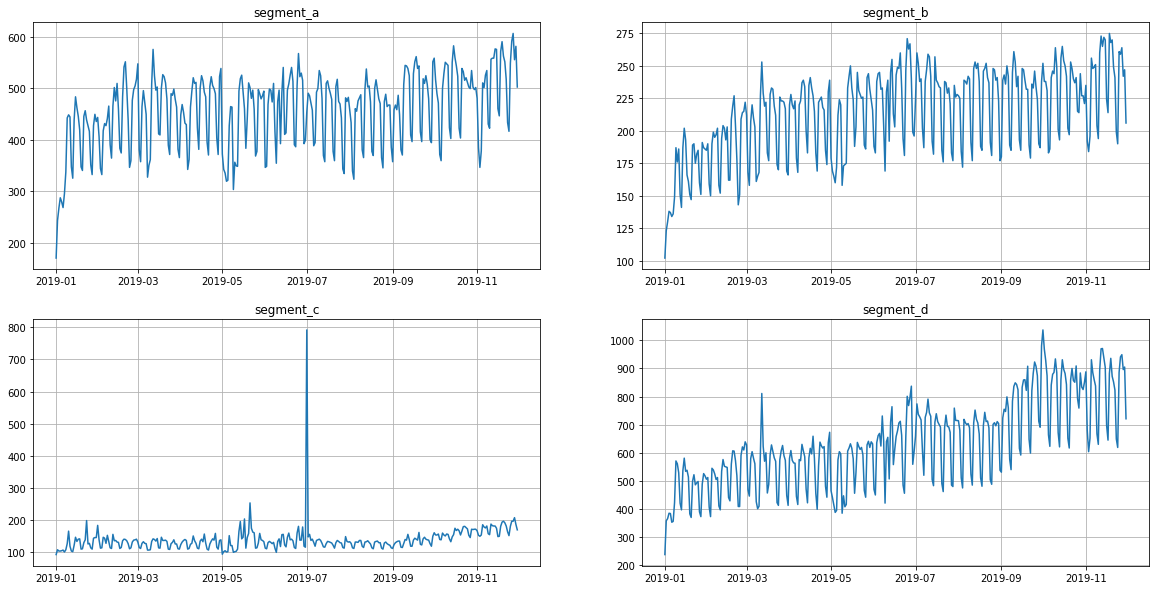

In [51]:
ts.plot()

In [52]:
from etna.models.nn.deepstate.deepstate import DeepStateModel
from etna.models.nn.deepstate.state_space_model import CompositeSSM, WeeklySeasonalitySSM

In [54]:
horizon = 7
seq_lenght = 28
model = DeepStateModel(
    ssm = CompositeSSM(seasonal_ssms=[WeeklySeasonalitySSM()], nonseasonal_ssm=None),
    input_size=3,
    encoder_length=seq_lenght,
    decoder_length=horizon,
    train_batch_size=16,
    test_batch_size=16,
    trainer_params=dict(max_epochs=5),
)

In [55]:
from etna.pipeline import Pipeline
from etna.metrics import SMAPE
from etna.transforms import DateFlagsTransform, StandardScalerTransform, SegmentEncoderTransform, LagTransform

In [56]:
pipeline = Pipeline(model=model, transforms=[SegmentEncoderTransform(), StandardScalerTransform(in_column="target"), LagTransform(in_column="target", lags=[horizon,horizon+1]),], horizon=horizon)

In [57]:
metrics, forecast, _ = pipeline.backtest(ts, metrics=[SMAPE()], n_folds=1, n_jobs=1) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /Users/a.p.chikov/PycharmProjects/etna_dev/etna-ts/etna/models/nn/deepstate/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name       | Type       | P

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


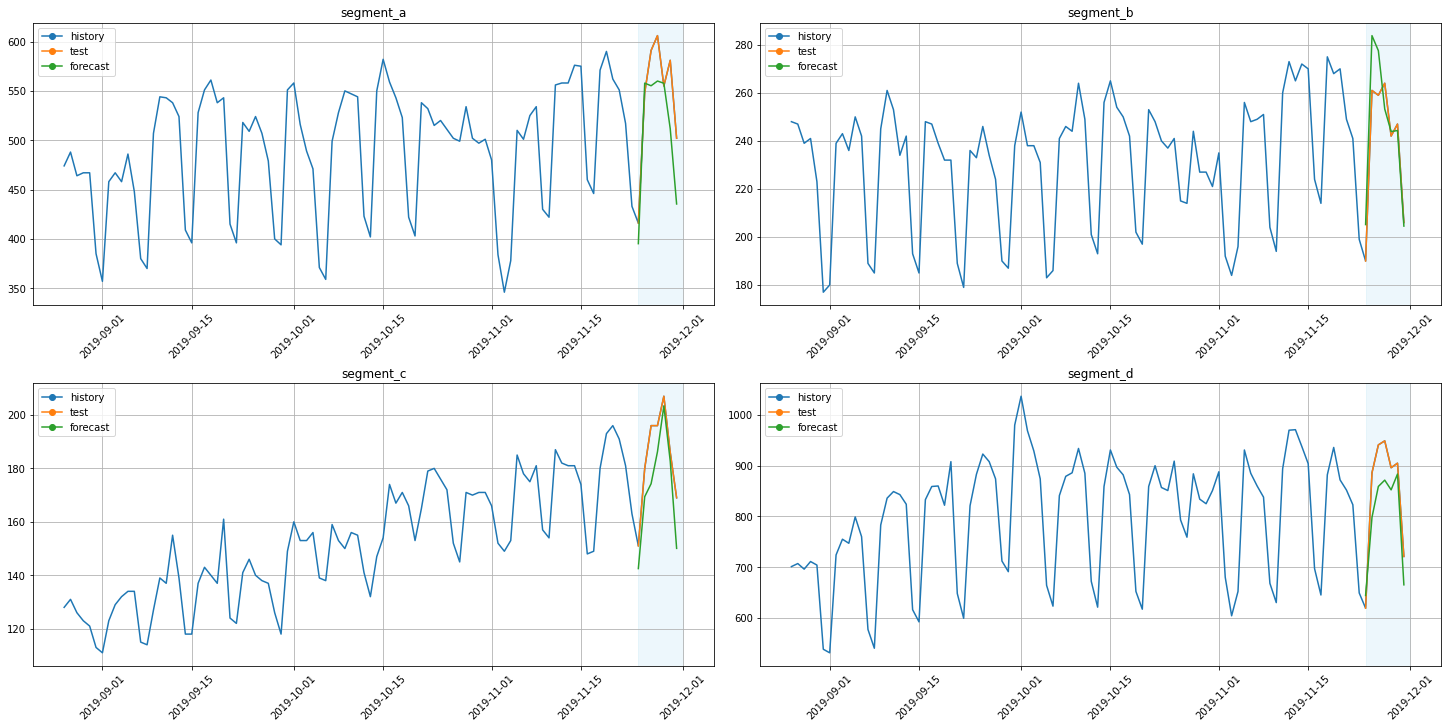

In [58]:
plot_backtest(forecast, ts, history_len=90)

In [59]:
metrics

,segment,SMAPE,fold_number
0,segment_a,6.921237,0
1,segment_b,4.245651,0
2,segment_c,6.298713,0
3,segment_d,6.784548,0
